## Tune parameters for Ridge and Lasso Classifiers

### Requirements:
1. Features for each position

### Instructions:
Run cells in order

In [1]:
import numpy as np
import pandas as pd
import cPickle as pickle
import random
import warnings
from scipy.stats import uniform as sp_rand
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# Models
from sklearn.linear_model import Lasso, Ridge, RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import ensemble

### Load data and separate negative/positive examples

In [2]:
curr_dir = !pwd
input_path = curr_dir[0]+"/../9.Features_exploration/binding_df/10/"
#filename = "positions_features_08.08.17.csv" # Old version
filename = "positions_features_11.30.17.csv"
bind_scores_num = 10

features_all = pd.read_csv(input_path+filename, sep='\t', index_col=0)
features_cols = features_all.columns[1:-bind_scores_num] # Removing binding scores and domain name
#ligands = ["dna", "rna", "peptide", "ion", "metabolite"] # Old groups
ligands = ["ion", "metabolite","dna", "dnabase", "dnabackbone", "rna", "rnabase", "rnabackbone", "peptide"]

# Get relevant models
models = {}
models["Ridge Classifier"] = RidgeClassifier()
models["Lasso"] = Lasso()
models["Ridge Regressor"] = Ridge()

In [3]:
# Negative examples
non_binding_positions = features_all[features_all["max_binding_score"] == 0]
non_binding_positions = non_binding_positions.loc[:,features_cols]

In [4]:
# Positive examples
bind_th = 0.1
ligands_features_df = {}

for ligand in ligands:
    score_col_str = ligand+"_binding_score"
    ligand_binding_df = features_all[features_all[score_col_str] >= bind_th]
    ligands_features_df[ligand] = ligand_binding_df.loc[:,features_cols]

### Functions for sampling

In [5]:
def sample(iterator, k):
    """
    Samples k elements from an iterable object.

    :param iterator: an object that is iterable
    :param k: the number of items to sample
    """
    # fill the reservoir to start
    result = [next(iterator) for _ in range(k)]

    n = k - 1
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item

    return result

In [6]:
# Down-sample to get a balanced class with max number of positives
def get_sample(ligand_bind_features, non_binding_positions):
    # Get the data
    negative_idx = range(0,len(non_binding_positions))
    sampled_negative_idx = sample(iter(negative_idx), len(ligand_bind_features))
    X = pd.concat([ligand_bind_features, non_binding_positions.iloc[sampled_negative_idx]])

    # Get the target
    y = [1] * ligand_bind_features.shape[0]
    y.extend([0] * ligand_bind_features.shape[0])
    y = np.array(y)
    
    # Shuffle both
    indices = range(0,len(y))
    np.random.shuffle(indices)
    X = X.iloc[indices,:]
    y = y[indices]
    return [X,y]

### Function to convert continuous output from regressor to binary classification metric

In [7]:
def regression_scoring(y,pred):
    pred = np.asarray(pred)
    pred = (pred > 0.5).astype(int)
    return metrics.roc_auc_score(y,pred)
    #return metrics.accuracy_score(y,pred)

### Test alpha values for training on balanced, testing on unbalanced

In [8]:
def tune_params(models, n_iter, **kwargs):
    """
    Tunes the given parameters in the given models using iterated grid
    search and plot the results as histograms.

    :param models: a list of the models
    :param n_iter: the number of iterations of grid search
    :param **kwargs: the values of the parameters to be tuned
    """

    # Check input and save default params
    default = {}
    for model in models:
        default[model] = {}
        m = models[model]
        for param in kwargs:
            if param not in m.get_params():
                raise ValueError("Parameter {0} is not valid for model {1}".format(param,model))
            default[model][param] = getattr(m,param)

    # Fit model, testing each param val for each ligand
    for model in models:
        print("***   " + model + "   ***\n")
        m = models[model]
        for param in kwargs:
            # Restore original setting for next param
            setattr(m,param,default[model][param])
            # For histograms
            ticks = [str(i) for i in kwargs[param]]
            plot_dict = dict(zip(kwargs[param],range(1,len(kwargs[param])+1)))
            for ligand in ligands:                
                # Create X and y
                ligand_bind_features = ligands_features_df[ligand]
                X = pd.concat([ligand_bind_features, non_binding_positions])

                y = [1] * ligand_bind_features.shape[0]
                y.extend([0] * non_binding_positions.shape[0])
                y = np.array(y)
                # Get scores
                param_vals = np.zeros([n_iter])
                for i in range(0,n_iter):
                    best_score = -1
                    best_param_val = -1
                    for param_val in kwargs[param]:
                        setattr(m,param,param_val)
                        binding_skf = StratifiedKFold(n_splits=2)
                        score = 0
                        for train_index, test_index in binding_skf.split(X, y):
                            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
                            y_train, y_test = y[train_index], y[test_index]

                            # Down-sample negative examples to have balanced classes
                            negative_idx = np.where(y_train == 0)[0].tolist()
                            positive_idx = np.where(y_train == 1)[0].tolist()
                            sampled_negative_idx = sample(iter(negative_idx), len(positive_idx))
                            X_train_sampled = pd.concat([X_train.iloc[positive_idx], X_train.iloc[sampled_negative_idx]])
                            y_train_sampled = np.append(y_train[positive_idx], [0] * len(positive_idx))

                            # Fit to training data
                            m.fit(X_train_sampled, y_train_sampled)
                            predicted = m.predict(X_test)
                            score += regression_scoring(y_test,predicted)

                        if score > best_score:
                            best_score = score
                            best_param_val = param_val
                    param_vals[i] = plot_dict[best_param_val]
                # Plot histogram
                plt.hist(param_vals,bins=np.arange(0.5,10.5),alpha=0.75,ec='black')
                plt.xlabel(str(param)+" value")
                plt.ylabel("Count")
                plt.title(ligand)
                plt.xticks(range(1,len(kwargs[param])+1),ticks,rotation='horizontal')
                plt.show()
        print("\n")

### Results for Lasso, SVM, KNN, RF, and Ridge

***   Lasso   ***



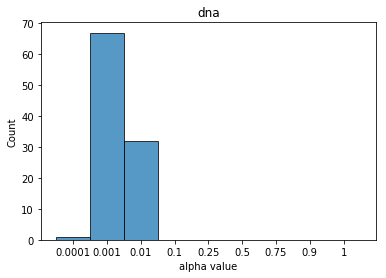

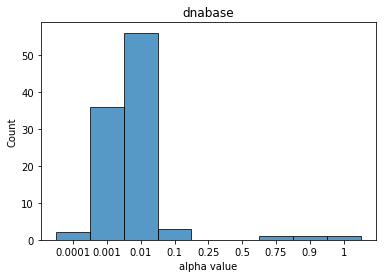

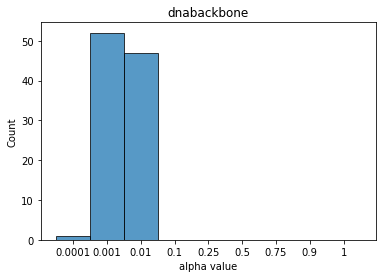

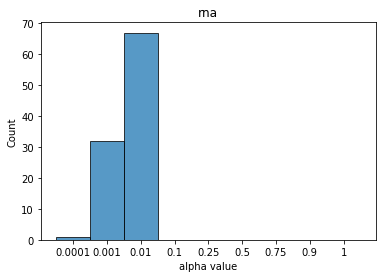

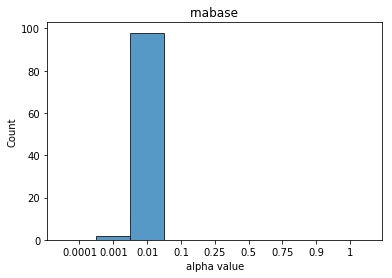

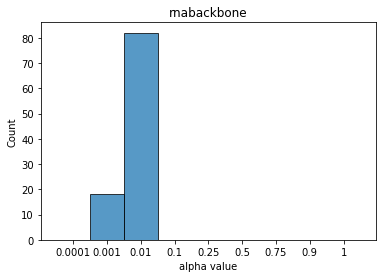

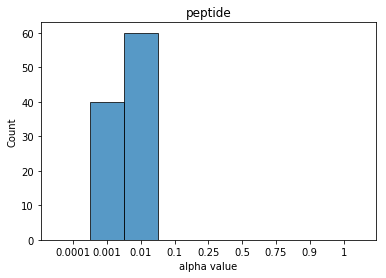

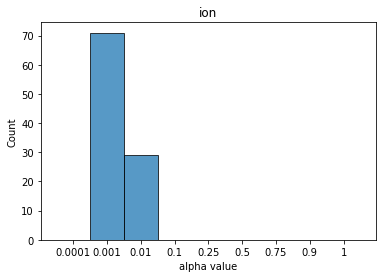

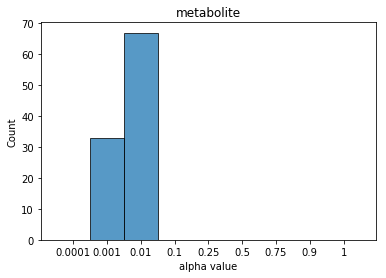



CPU times: user 2h 26min 25s, sys: 28min 49s, total: 2h 55min 15s
Wall time: 2h 51min 16s


In [36]:
%%time

warnings.filterwarnings('ignore')

models = {}
models["Lasso"] = Lasso()
n_iter = 100

tune_params(models,n_iter,alpha=[0.0001,0.001,0.01,0.1,0.25,0.5,0.75,0.9,1])

***   SVM   ***



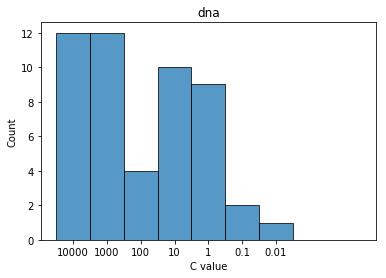

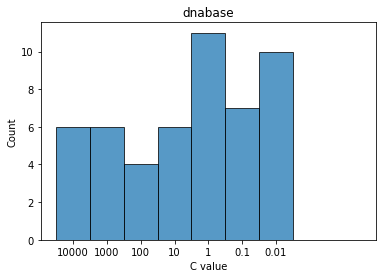

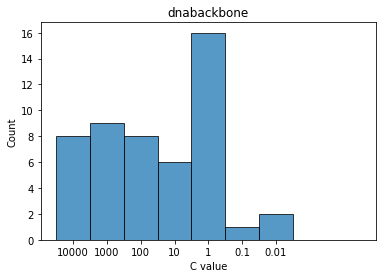

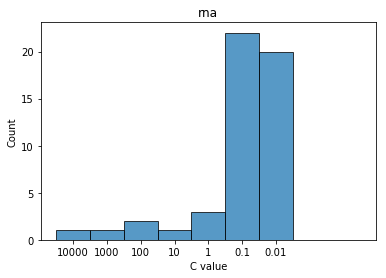

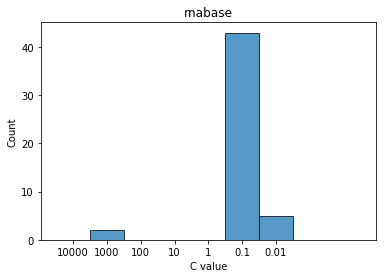

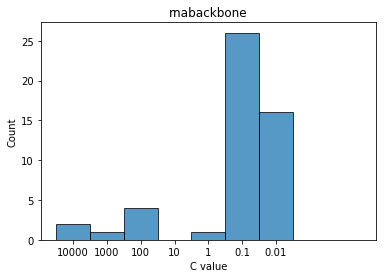

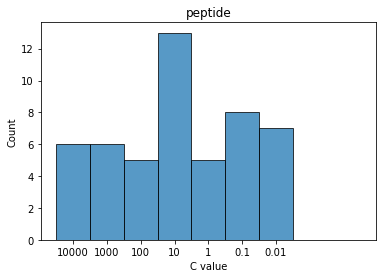

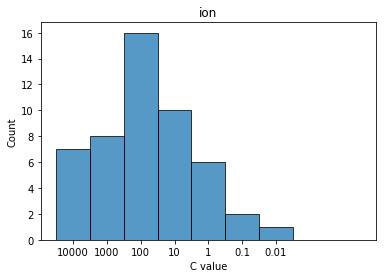

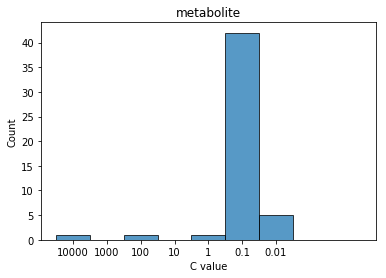

In [20]:
## %%time

warnings.filterwarnings('ignore')

models = {}
models["SVM"] = svm.SVC()
n_iter = 50

tune_params(models,n_iter,C=[10000,1000,100,10,1,0.1,0.01]) #,gamma=[0.00001,0.0001,0.001,0.01,0.1,1])

***   SVM   ***



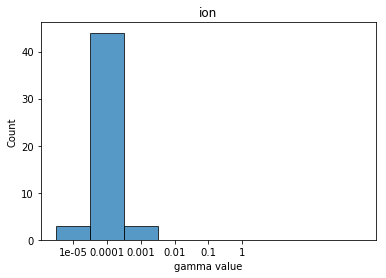

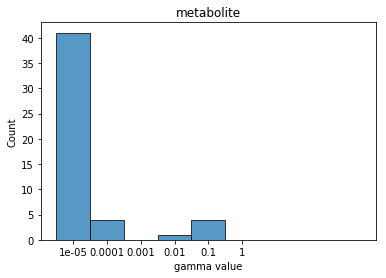

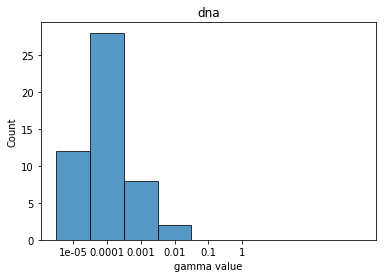

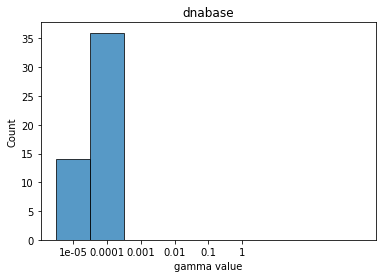

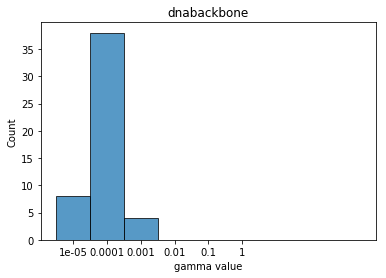

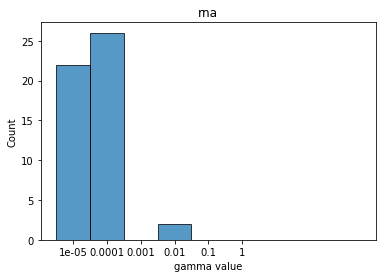

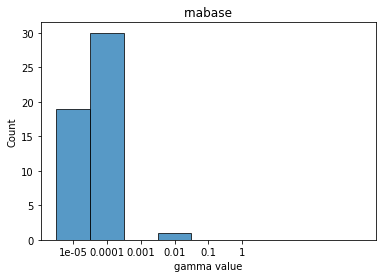

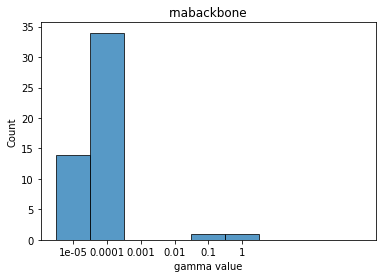

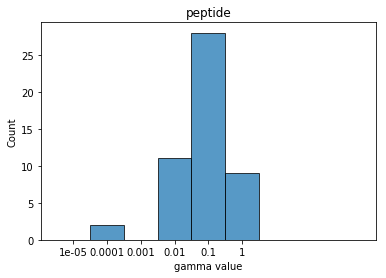

In [9]:
## %%time

warnings.filterwarnings('ignore')

models = {}
models["SVM"] = svm.SVC()
n_iter = 50

tune_params(models,n_iter,gamma=[0.00001,0.0001,0.001,0.01,0.1,1])

***   KNN   ***



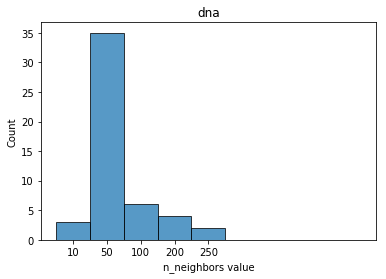

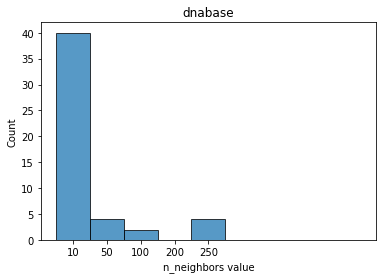

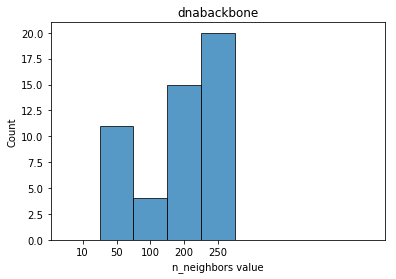

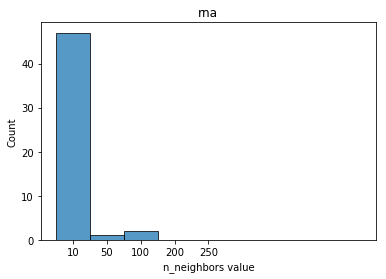

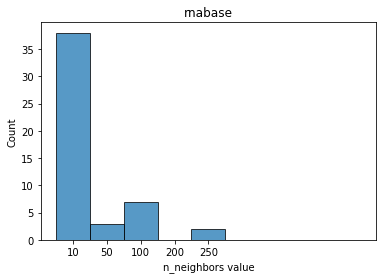

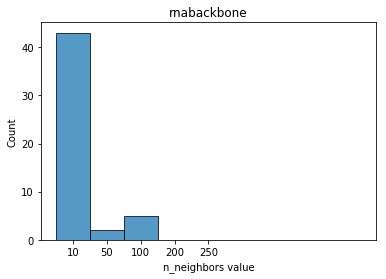

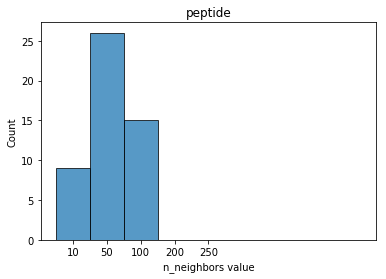

In [ ]:
## %%time

warnings.filterwarnings('ignore')

models = {}
models["KNN"] = KNeighborsClassifier()
n_iter = 50

tune_params(models,n_iter,n_neighbors=[10,50,100,200,250])

***   KNN   ***



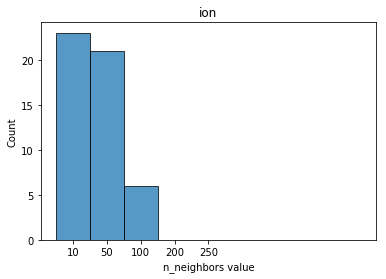

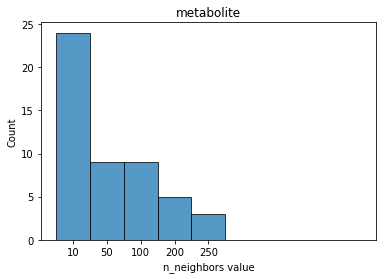

KeyboardInterrupt: 

In [11]:
warnings.filterwarnings('ignore')

models = {}
models["KNN"] = KNeighborsClassifier()
n_iter = 50

tune_params(models,n_iter,n_neighbors=[10,50,100,200,250])

***   RF   ***



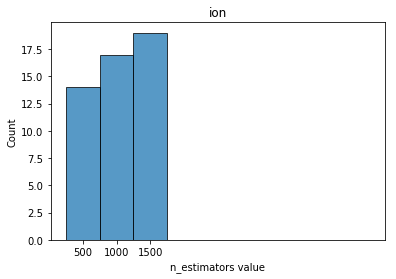

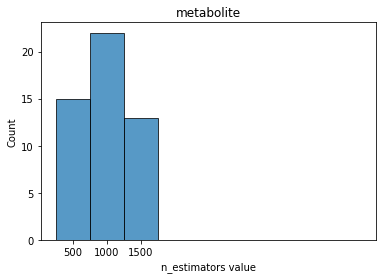

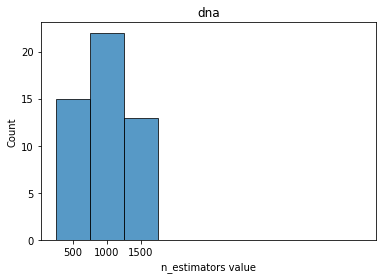

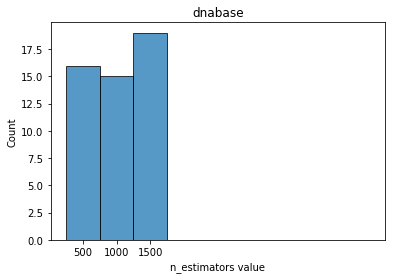

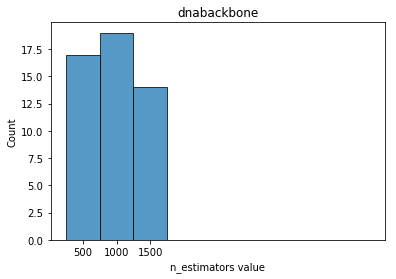

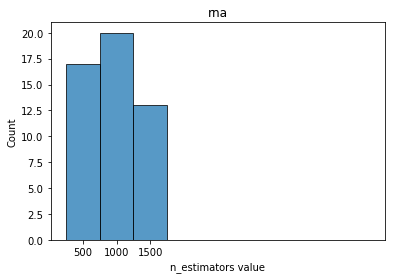

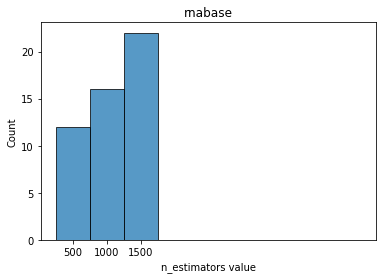

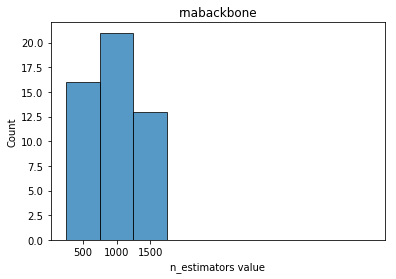

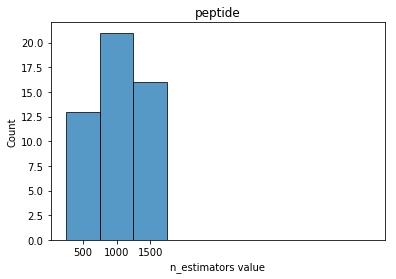

In [9]:
warnings.filterwarnings('ignore')

models = {}
models["RF"] = ensemble.RandomForestRegressor()
n_iter = 50

tune_params(models,n_iter,n_estimators=[500,1000,1500])

***   Ridge Classifier   ***



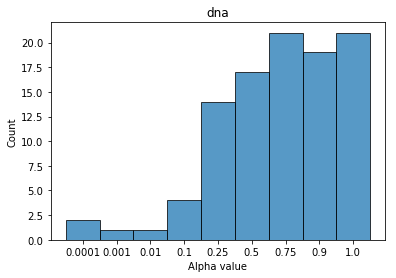

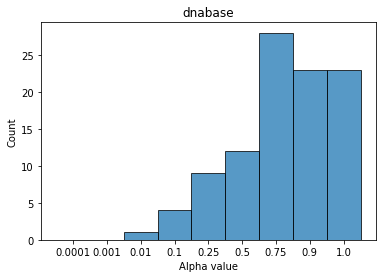

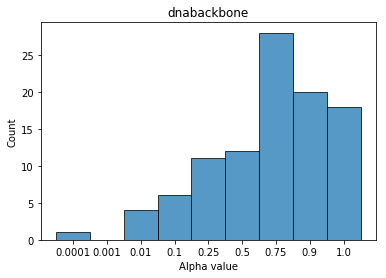

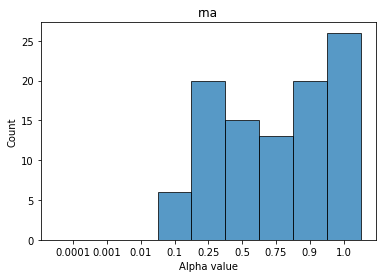

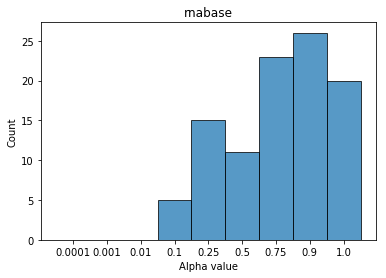

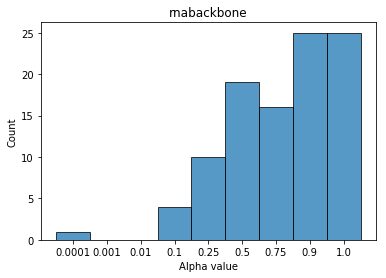

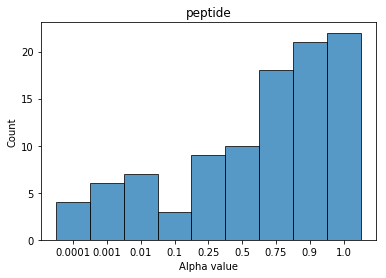

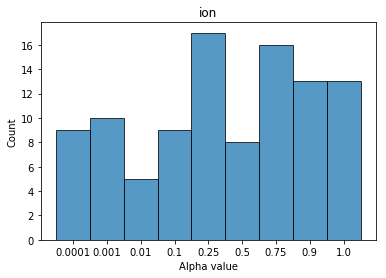

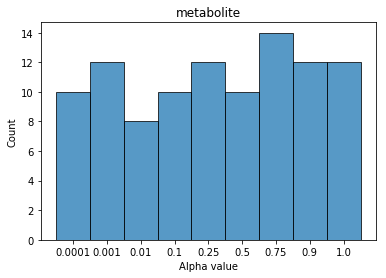



***   Ridge Regressor   ***



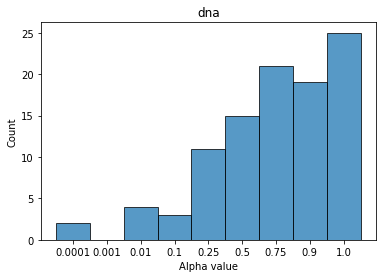

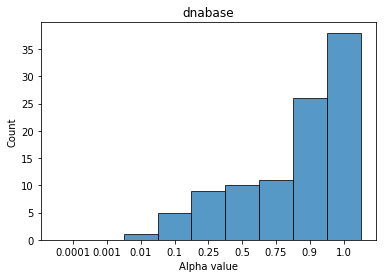

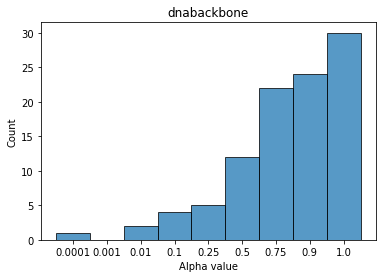

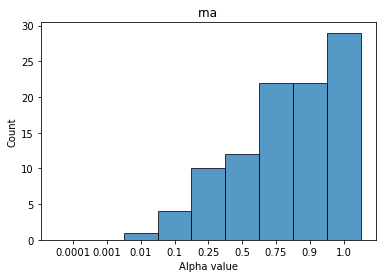

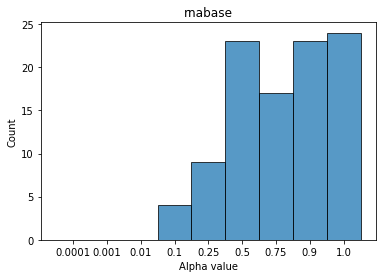

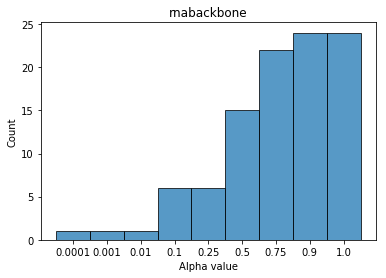

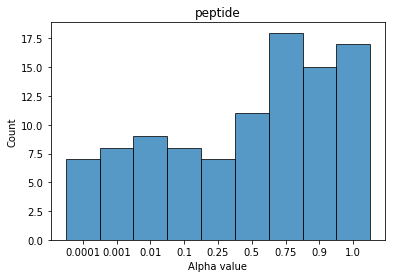

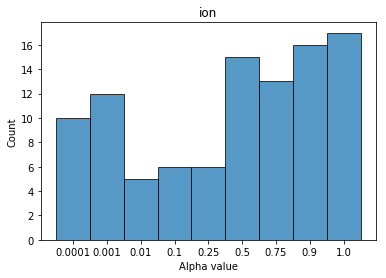

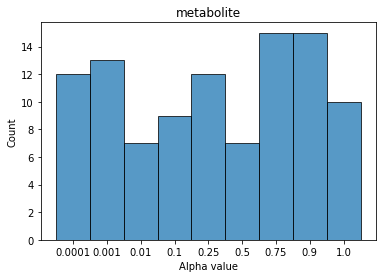



***   Lasso   ***



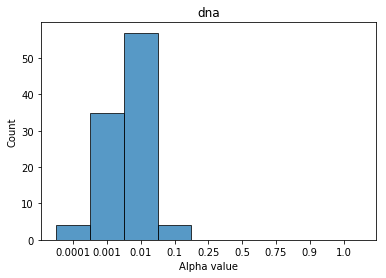

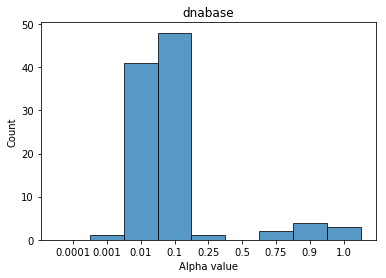

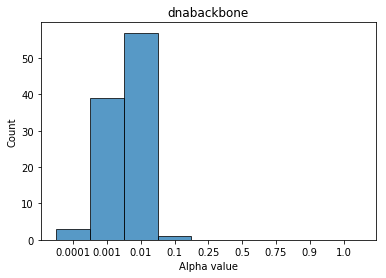

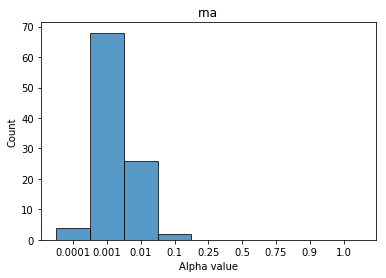

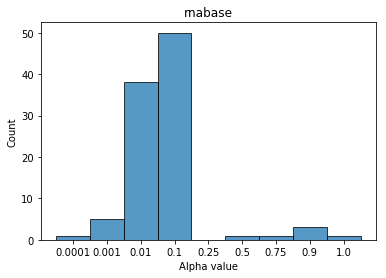

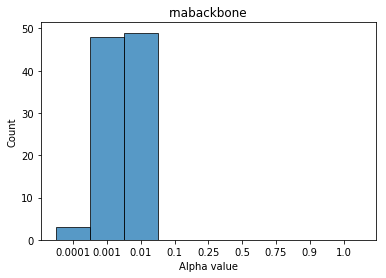

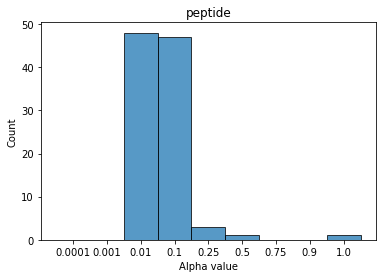

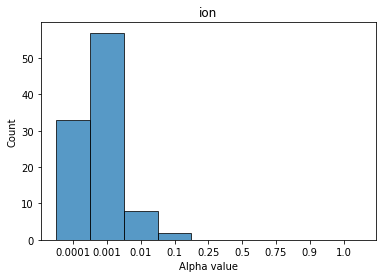

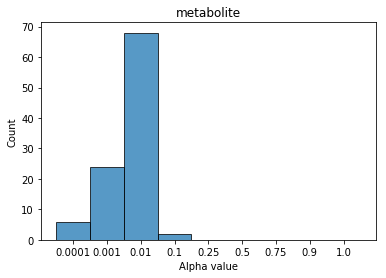

In [41]:
## Ridge and Lasso

warnings.filterwarnings('ignore')

# Grid Search for Algorithm Tuning
n_iter = 100

# Prepare a range of alpha values to test
alphas = np.array([0.0001,0.001,0.01,0.1,0.25,0.5,0.75,0.9,1])

# For histograms
ticks = [str(i) for i in alphas]
plot_dict = dict(zip(alphas,range(1,len(alphas)+1)))

# Define scoring function
score = metrics.make_scorer(regression_scoring, greater_is_better=True)

# Create and fit a ridge regression model, testing each alpha for each ligand
for model in models:
    print("***   " + model + "   ***\n")
    m = models[model]
    for ligand in ligands:
        # Create X and y
        ligand_bind_features = ligands_features_df[ligand]
        X = pd.concat([ligand_bind_features, non_binding_positions])

        y = [1] * ligand_bind_features.shape[0]
        y.extend([0] * non_binding_positions.shape[0])
        y = np.array(y)
        # Get scores
        alpha_vals = np.zeros([n_iter])
        for i in range(0,n_iter):
            best_score = -1
            best_alpha = -1
            for alpha in alphas:
                m = m.set_params(alpha=alpha)
                binding_skf = StratifiedKFold(n_splits=2)
                score = 0
                for train_index, test_index in binding_skf.split(X, y):
                    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
                    y_train, y_test = y[train_index], y[test_index]

                    #Down-sample negative examples to have balanced classes
                    negative_idx = np.where(y_train == 0)[0].tolist()
                    positive_idx = np.where(y_train == 1)[0].tolist()
                    sampled_negative_idx = sample(iter(negative_idx), len(positive_idx))
                    X_train_sampled = pd.concat([X_train.iloc[positive_idx], X_train.iloc[sampled_negative_idx]])
                    y_train_sampled = np.append(y_train[positive_idx], [0] * len(positive_idx))

                    #fit to training data
                    m.fit(X_train_sampled, y_train_sampled)
                    predicted = m.predict(X_test)
                    score += regression_scoring(y_test,predicted)

                if score > best_score:
                    best_score = score
                    best_alpha = alpha
            alpha_vals[i] = plot_dict[best_alpha]
        # Plot histogram
        plt.hist(alpha_vals,bins=np.arange(0.5,10.5),alpha=0.75,ec='black')
        plt.xlabel("Alpha value")
        plt.ylabel("Count")
        plt.title(ligand)
        plt.xticks(range(1,len(alphas)+1),ticks,rotation='horizontal')
        plt.show()
    print("\n")

### Best alpha values based on results

In [6]:
params_dict = {
    "dna": {
        "Lasso": {"alpha": 0.001},
        "Ridge": {"alpha": 1},
        "SVM": {"C": 1000, "gamma": 0.0001},
        "KNN": {"n_neighbors": 50},
    },
    "dnabase": {
        "Lasso": {"alpha": 0.01},
        "Ridge": {"alpha": 0.75},
        "SVM": {"C": 1, "gamma": 0.0001},
        "KNN": {"n_neighbors": 10},
    },
    "dnabackbone": {
        "Lasso": {"alpha": 0.001},
        "Ridge": {"alpha": 0.75},
        "SVM": {"C": 1, "gamma": 0.0001},
        "KNN": {"n_neighbors": 250},
    },
    "rna": {
        "Lasso": {"alpha": 0.01},
        "Ridge": {"alpha": 1},
        "SVM": {"C": 0.1, "gamma": 0.0001},
        "KNN": {"n_neighbors": 10},
    },
    "rnabase": {
        "Lasso": {"alpha": 0.01},
        "Ridge": {"alpha": 0.9},
        "SVM": {"C": 0.1, "gamma": 0.0001},
        "KNN": {"n_neighbors": 10},
    },
    "rnabackbone": {
        "Lasso": {"alpha": 0.01},
        "Ridge": {"alpha": 0.9},
        "SVM": {"C": 0.1, "gamma": 0.0001},
        "KNN": {"n_neighbors": 10},
    },
    "peptide": {
        "Lasso": {"alpha": 0.01},
        "Ridge": {"alpha": 1},
        "SVM": {"C": 10, "gamma": 0.1},
        "KNN": {"n_neighbors": 50},
    },
    "ion": {
        "Lasso": {"alpha": 0.001},
        "Ridge": {"alpha": 0.25},
        "SVM": {"C": 100, "gamma": 0.0001},
        "KNN": {"n_neighbors": 10},
    },
    "metabolite": {
        "Lasso": {"alpha": 0.01},
        "Ridge": {"alpha": 0.75},
        "SVM": {"C": 0.1, "gamma": 0.00001},
        "KNN": {"n_neighbors": 10},
    }
}

with open('opt_params.pik', 'wb') as handle:
    pickle.dump(params_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Below are exploratory analyses — feel free to ignore

***   Ridge Classifier   ***



//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.35668542877e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.43795781574e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


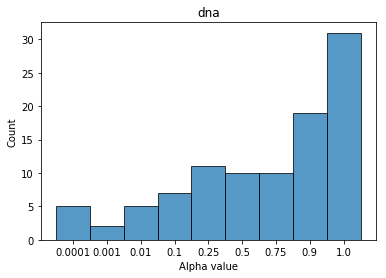

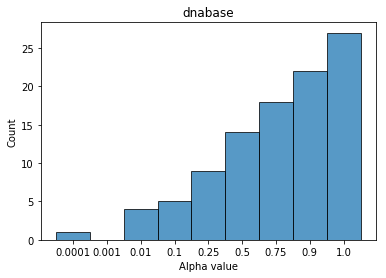

//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.59505376378e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.50619237462e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


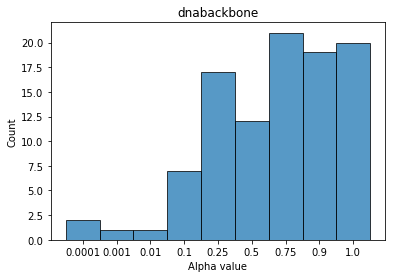

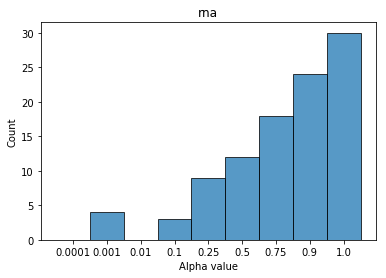

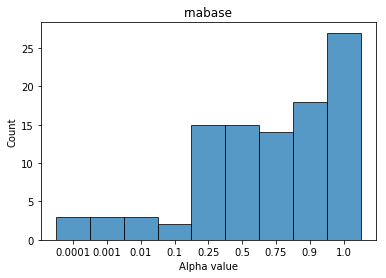

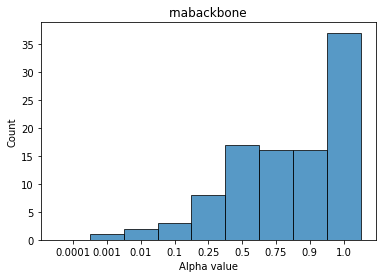

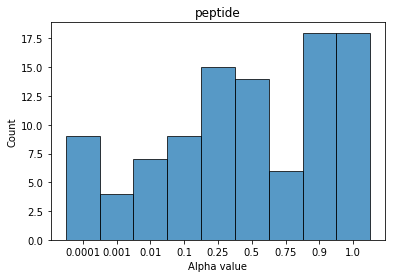

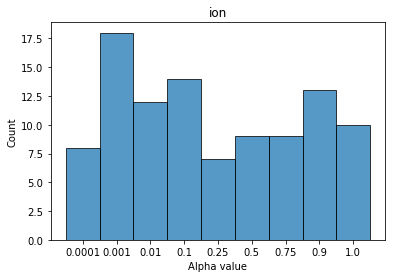

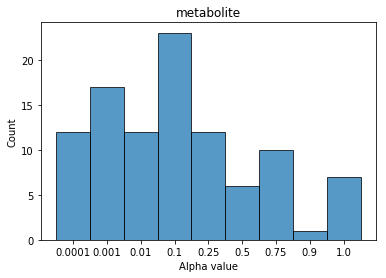



***   Ridge Regressor   ***



//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.72279290163e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.75564795579e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.19671969971e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


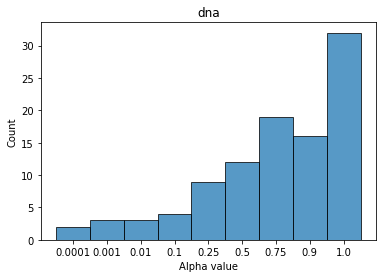

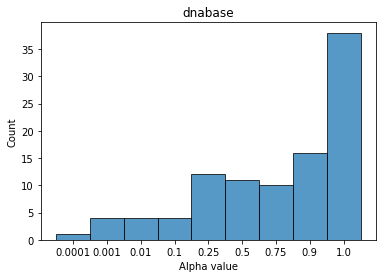

//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.08426885321e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.53976252018e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 7.80721237726e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


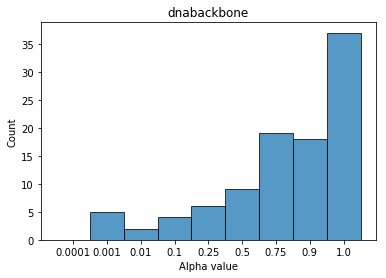

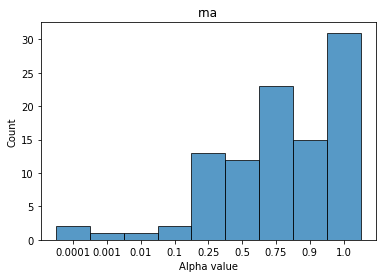

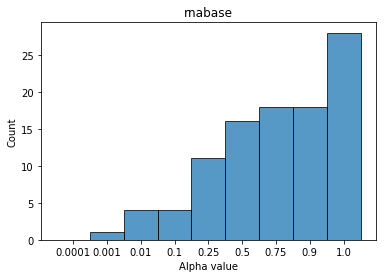

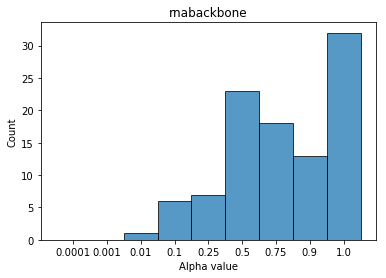

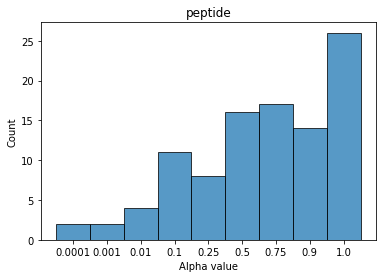

//anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.1686195306e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


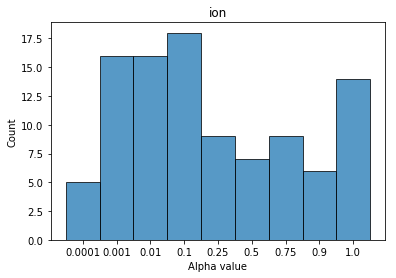

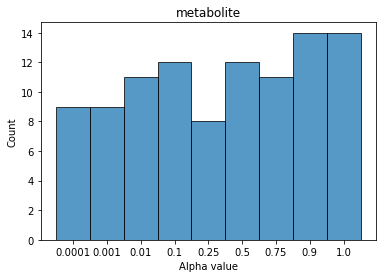



***   Lasso   ***



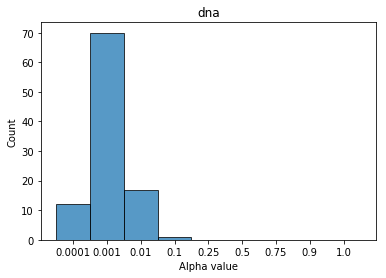

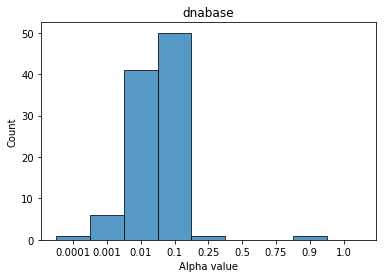

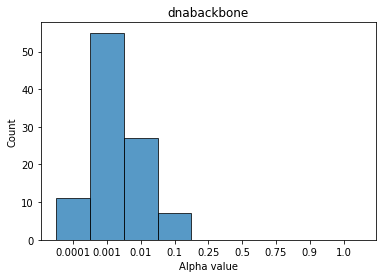

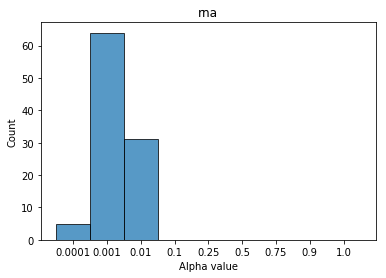

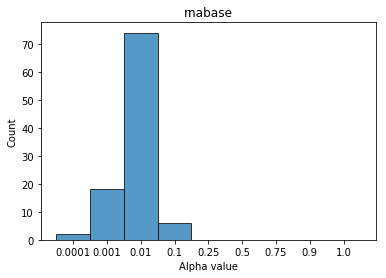

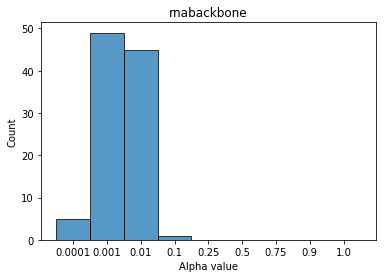

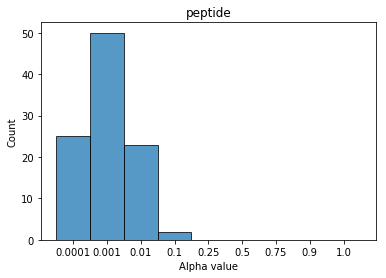

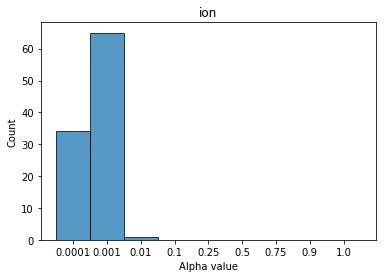

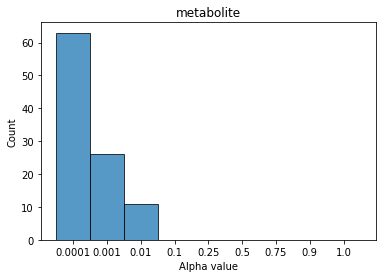

In [122]:
# Grid Search for Algorithm Tuning
n_iter = 100

# Prepare a range of alpha values to test
alphas = np.array([0.0001,0.001,0.01,0.1,0.25,0.5,0.75,0.9,1])

# For histograms
ticks = [str(i) for i in alphas]
plot_dict = dict(zip(alphas,range(1,len(alphas)+1)))

# Define scoring function
score = metrics.make_scorer(regression_scoring, greater_is_better=True)

# Create and fit a ridge regression model, testing each alpha for each ligand
for model in models:
    print("***   " + model + "   ***\n")
    for ligand in ligands:
        # Get scores
        alpha_vals = np.zeros([n_iter])
        for i in range(0,n_iter):
            [X,y] = get_sample(ligands_features_df[ligand], non_binding_positions)
            grid = GridSearchCV(estimator=models[model], param_grid=dict(alpha=alphas),
                                scoring=score)
            grid.fit(X,y)
            alpha_vals[i] = plot_dict[grid.best_estimator_.alpha]
    
        # Plot histogram
        plt.hist(alpha_vals,bins=np.arange(0.5,10.5),alpha=0.75,ec='black')
        plt.xlabel("Alpha value")
        plt.ylabel("Count")
        plt.title(ligand)
        plt.xticks(range(1,len(alphas)+1),ticks,rotation='horizontal')
        plt.show()
    print("\n")

In [10]:
# Random Search for Algorithm Tuning

# Define scoring function
score = metrics.make_scorer(regression_scoring, greater_is_better=True)

# Create and fit a ridge regression model, testing each alpha for each ligand
for model in models:
    print("***   " + model + "   ***\n")
    for ligand in ligands:
        # Get balanced sample and fit model
        [X,y] = get_sample(ligands_features_df[ligand], non_binding_positions)
        param_grid = {'alpha': sp_rand()}
        rsearch = RandomizedSearchCV(estimator=models[model], param_distributions=param_grid, n_iter=100,
                                     scoring=score)
        rsearch.fit(X,y)

        # Summarize the results of the grid search
        print(ligand + ": ")
        print(rsearch.best_score_)
        print(rsearch.best_estimator_.alpha)
    print("\n")

***   Ridge Classifier   ***

dna: 
0.698931909212
0.824029513495
dnabase: 
0.582437275986
0.216743203944
dnabackbone: 
0.6968
0.576282425587
rna: 
0.681240063593
0.630233384625
rnabase: 
0.663043478261
0.99134853021
rnabackbone: 
0.664847161572
0.987772900811
peptide: 
0.602853198343
0.286726850972
ion: 
0.647841513897
0.158573546692
metabolite: 
0.584400189663
0.00561740292122


***   Lasso Regression   ***

dna: 
0.381842456609
0.00392553255779
dnabase: 
0.435483870968
0.00181899795594
dnabackbone: 
0.516
0.000261584827326
rna: 
0.360890302067
0.00839719087209
rnabase: 
0.343167701863
0.037061432103
rnabackbone: 
0.446506550218
0.00153123845686
peptide: 
0.275195582145
0.0221691774851
ion: 
0.32170313424
0.00186072838975
metabolite: 
0.208629682314
0.0141064186981


***   Ridge Regression   ***

dna: 
0.4826435247
0.0342650512814
dnabase: 
0.501792114695
0.000105371033933
dnabackbone: 
0.5112
0.000857637171636
rna: 
0.47853736089
0.111085982522
rnabase: 
0.534161490683
0.05826046938

In [29]:
# Grid Search to tune Logistic Regression norm

# Parameters to tune
penalties = np.array(['l1','l2'])

# Define scoring function
score = metrics.make_scorer(regression_scoring, greater_is_better=True)

# Create and fit a ridge regression model, testing each alpha for each ligand
model = LogisticRegression()
print("***   Logistic Regression   ***\n")
for ligand in ligands:
    # Get balanced sample and fit model
    [X,y] = get_sample(ligands_features_df[ligand], non_binding_positions)
    grid = GridSearchCV(estimator=model, param_grid=dict(penalty=penalties),
                        scoring='accuracy')
    grid.fit(X,y)

    # Summarize the results of the grid search
    print(ligand + ": ")
    print(grid.best_score_)
    print(grid.best_estimator_.penalty)
print("\n")

***   Logistic Regression   ***

dna: 
0.691588785047
l1
dnabase: 
0.637992831541
l1
dnabackbone: 
0.7256
l1
rna: 
0.676470588235
l1
rnabase: 
0.645962732919
l1
rnabackbone: 
0.649563318777
l1
peptide: 
0.587666820064
l1
ion: 
0.637492607924
l1
metabolite: 
0.577761972499
l1




In [41]:
# Grid Search to tune c and gamma parameters in SVM

# Parameters to tune
c_values = np.array([10000,1000,100,10,1,0.1,0.01])
gammas = np.array([0.00001,0.0001,0.001,0.01,0.1,1])

# Define scoring function
score = metrics.make_scorer(regression_scoring, greater_is_better=True)

# Create and fit a ridge regression model, testing each alpha for each ligand
print("***   SVM   ***\n")
for ligand in ligands:
    # Get balanced sample and fit model for C
    model = svm.SVC(kernel='rbf')
    [X,y] = get_sample(ligands_features_df[ligand], non_binding_positions)
    grid = GridSearchCV(estimator=model, param_grid=dict(C=c_values),
                        scoring='accuracy')
    X = pd.DataFrame(scale(X))
    grid.fit(X,y)
    best_c = grid.best_estimator_.C
    
    # Resample and fit for gamma
    model = svm.SVC(kernel='rbf',C=best_c)
    [X,y] = get_sample(ligands_features_df[ligand], non_binding_positions)
    grid = GridSearchCV(estimator=model, param_grid=dict(gamma=gammas),
                        scoring='accuracy')
    X = pd.DataFrame(scale(X))
    grid.fit(X,y)
    
    # Summarize the results of the grid search
    print(ligand + ": ")
    print(grid.best_score_)
    print("C: " + str(best_c))
    print("Gamma: " + str(grid.best_estimator_.gamma))
    print("\n")

***   SVM   ***

dna: 
0.690921228304
C: 10.0
Gamma: 0.001
dnabase: 
0.621863799283
C: 1.0
Gamma: 0.01
dnabackbone: 
0.7064
C: 10000.0
Gamma: 1e-05
rna: 
0.676470588235
C: 1.0
Gamma: 0.01
rnabase: 
0.673913043478
C: 1.0
Gamma: 0.001
rnabackbone: 
0.697598253275
C: 1.0
Gamma: 0.01
peptide: 
0.624482282559
C: 1.0
Gamma: 0.001
ion: 
0.658781785925
C: 1.0
Gamma: 0.001
metabolite: 
0.591275486012
C: 1.0
Gamma: 0.001




In [48]:
# Grid Search to tune neighbors in KNN

# Prepare a range of alpha values to test
neighbors = np.array([10,50,100,200,300])

# Define scoring function
score = metrics.make_scorer(regression_scoring, greater_is_better=True)

# Create and fit a ridge regression model, testing each alpha for each ligand
model = KNeighborsClassifier()
print("***   KNN   ***\n")
for ligand in ligands:
    # Get balanced sample and fit model
    [X,y] = get_sample(ligands_features_df[ligand], non_binding_positions)
    grid = GridSearchCV(estimator=model, param_grid=dict(n_neighbors=neighbors),
                        scoring=score)
    X = pd.DataFrame(scale(X))
    grid.fit(X,y)

    # Summarize the results of the grid search
    print(ligand + ": ")
    print(grid.best_score_)
    print(str(grid.best_estimator_.n_neighbors) + "\n")

***   KNN   ***

dna: 
0.681575433912
100


dnabase: 
0.593189964158
10


dnabackbone: 
0.7008
200


rna: 
0.626391096979
50


rnabase: 
0.608695652174
10


rnabackbone: 
0.613537117904
10


peptide: 
0.594109526001
300


ion: 
0.645180366647
10


metabolite: 
0.574205784732
100


